In [19]:
import sys
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sb

In [25]:
load = pd.read_csv("CDC_Survey_2015.csv", low_memory = False)
df_fill_na = load.replace(r'^\s*$', np.nan, regex=True)
df = df_fill_na.dropna()
df = df.applymap(str)

arrBMI = np.array(df['BMI']).astype(np.float32)
df = df.drop(['BMI'], axis=1)
newAtt = []
for i in range(len(arrBMI)):
  if arrBMI[i] < 18.5:
    newAtt.append('0')  #Underweight
  elif arrBMI[i] < 25.:
    newAtt.append('1')  #Normal weight
  elif arrBMI[i] < 30.:
    newAtt.append('2')  #Overweight
  elif arrBMI[i] < 35.:
    newAtt.append('3')  #Obese
  else:
    newAtt.append('4')  #Extremely Obese

df.insert(0, 'BMI', newAtt)
        
arrHeart = np.array(df['HeartDiseaseorAttack'])
arrDia = np.array(df['Diabetes_011'])
df = df.drop(['HeartDiseaseorAttack', 'Diabetes_011'], axis=1)
newAtt = []
for i in range(len(arrHeart)):
    if arrHeart[i] == '0':
        if arrDia[i] == '0':
            newAtt.append('0') #No Heart disease, No Diabetes
        else:
            newAtt.append('1') #No Heart disease, Yes Diabetes
    else:
        if arrDia[i] == '0':
            newAtt.append('2') #Yes Heart disease, No Diabetes
        else:
            newAtt.append('3') #Yes Heart disease, Yes Diabetes

df.insert(0, 'HEART/DIA', newAtt)

new_df = df.groupby('HEART/DIA').sample(n=3500)

In [26]:
label_encoder = preprocessing.LabelEncoder()
new_df['HEART/DIA']= label_encoder.fit_transform(new_df['HEART/DIA'])

X = np.array(new_df.drop('HEART/DIA', axis=1)).astype(np.float32)
y = np.array(new_df['HEART/DIA']).astype(np.float32).flatten()

x_train, x_test, y_train, y_test = train_test_split(X,y ,
                                   random_state=104, 
                                   test_size=0.25, 
                                   shuffle=True)

In [33]:
model = Sequential([
    BatchNormalization(),
    Dense(21, activation = 'relu', name = 'first_layer'),
    Dense(10, activation = 'selu', name = 'second_layer'),
    # Dense(7, activation = 'elu', name = 'third_layer'),
    Dense(4, activation = 'softmax', name = 'last_layer')
])

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  
    optimizer=tf.keras.optimizers.Adam(0.008), #This is the more powerful optimizer than gradient descent. It can automatically adjust the learning rate alpha.
    metrics = ['accuracy']
)

model.fit(
    x_train, y_train,
    epochs = 40
)




Epoch 1/40
329/329 [==============================] - 3s 3ms/step - loss: 1.1744 - accuracy: 0.4702
Epoch 2/40
329/329 [==============================] - 1s 3ms/step - loss: 1.1464 - accuracy: 0.4808
Epoch 3/40
329/329 [==============================] - 1s 3ms/step - loss: 1.1413 - accuracy: 0.4849
Epoch 4/40
329/329 [==============================] - 1s 3ms/step - loss: 1.1387 - accuracy: 0.4875
Epoch 5/40
329/329 [==============================] - 1s 3ms/step - loss: 1.1382 - accuracy: 0.4896
Epoch 6/40
329/329 [==============================] - 1s 3ms/step - loss: 1.1358 - accuracy: 0.4907
Epoch 7/40
329/329 [==============================] - 1s 3ms/step - loss: 1.1345 - accuracy: 0.4902
Epoch 8/40
329/329 [==============================] - 1s 3ms/step - loss: 1.1337 - accuracy: 0.4890
Epoch 9/40
329/329 [==============================] - 1s 3ms/step - loss: 1.1314 - accuracy: 0.4922
Epoch 10/40
329/329 [==============================] - 1s 3ms/step - loss: 1.1311 - accuracy: 0.4935

In [34]:
model.evaluate(x_test, y_test)
model.summary()

110/110 [==============================] - 0s 2ms/step - loss: 1.1450 - accuracy: 0.4926
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 20)               80        
 hNormalization)                                                 
                                                                 
 first_layer (Dense)         (None, 21)                441       
                                                                 
 second_layer (Dense)        (None, 10)                220       
                                                                 
 last_layer (Dense)          (None, 4)                 44        
                                                                 
Total params: 785
Trainable params: 745
Non-trainable params: 40
_________________________________________________________________


110/110 [==============================] - 0s 2ms/step


Text(33.0, 0.5, 'Truth')

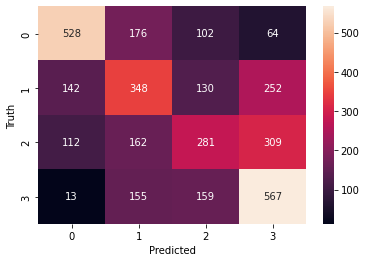

In [35]:
y_prediction = model.predict(x_test)
confuse = []
for i in range (len(x_test)):
    confuse.append(np.argmax(y_prediction[i]))
conf_matrix = np.array(tf.math.confusion_matrix(labels=y_test, predictions=confuse))

sb.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

0.48428571428571426


Text(33.0, 0.5, 'Truth')

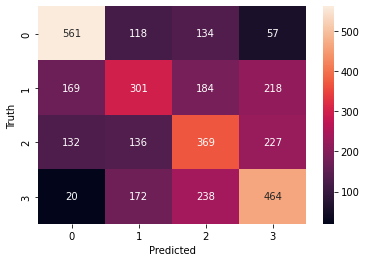

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

rf = RandomForestClassifier(max_depth=14, random_state=10000)
rf.fit(x_train, y_train)

rfcm = confusion_matrix(y_test, rf.predict(x_test).flatten())
print(rf.score(x_test, y_test))

sb.heatmap(rfcm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

0.5031428571428571


Text(33.0, 0.5, 'Truth')

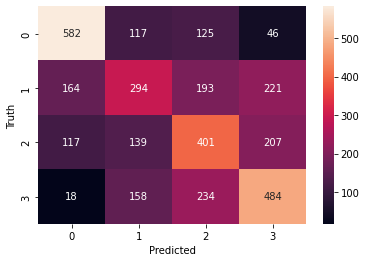

In [47]:
import xgboost as xgb

xg = xgb.XGBClassifier(random_state=10000).fit(x_train, y_train)

xgcm = confusion_matrix(y_test, xg.predict(x_test).flatten())
print(xg.score(x_test, y_test))

sb.heatmap(xgcm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')


We combine 2 features (HeartDiseaseorAttack and Diabetes_011) together into a single feature (HEART/DIA). There are 4 categories in this feature (0, 1, 2, 3). 
- '0': Doesn't have heart disease or diabetes
- '1': Only have diabetes
- '2': Only have heart disease
- '3': Have both heart disease and diabetes

For '0' and '2' XGBoost model provided the best predictions. For '1' and '3', neutral network provided the best predictions. But overall, if one 1 model was chosen for predicting, Random Forest will be the best.